# ATP Tennis Data - Reduced Feature Columns

For this notebook, I will remove some noise from our data to see if the models work better. Features that did not show up in our top 50 features from previous notebook where we combined history and matchup data will be used.

The following columns will be kept:

* p1_rank / p2_rank
* p1_history_games_won_percentage_diff
* p1_seed / p2_seed
* p1_height / p2_height
* p1_age / p2_age
* p1_matchup_games_won_percentage / p2_matchup_games_won_percentage
* p1_history_wins_diff
* p1_matchup_games_won_percentage / p2_matchup_games_won_percentage
* p1_matchup_sets_won_percentage/ p2_matchup_sets_won_percentage
* tourney_level_label
* surface_*
* best_of_*
* tourney_month
* p1_ioc_* (player origin)
* p1_* / p2_* (player id's)
* p1_history_sets_won_percentage_diff
* round_label


### Results from Best Model

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

# Summary of Results

Our results from Gradient Boosting is the following. Removing the rest of the features did little to affect the model accuracy (~0.3%)

```
Model Score: 0.6903443619176233

ROC/AUC Score: 0.6903161608528401
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL
import util.model_util as mu
import logging
import importlib

logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d %H:%m'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-reduced_history_matchup"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
import re

def filter_features(data: pd.DataFrame):
    
    print(f'\nBefore: data.shape {data.shape}')

    new_features = data[["p1_rank", "p2_rank", "p1_seed", "p2_seed", "p1_history_games_won_percentage_diff", "p1_history_sets_won_percentage_diff", 
                        "p1_ht", "p2_ht", "p1_age", "p2_age", "p1_matchup_games_won_percentage", "p2_matchup_games_won_percentage",
                        "p1_history_wins_diff", "tourney_level_label", "p1_matchup_sets_won_percentage", "p2_matchup_sets_won_percentage",
                        "tourney_month", "round_label"]]
             
    surface_cols = [col for col in data.columns if re.match("surface_", col)]
    new_features = pd.concat([new_features, data[surface_cols]], axis=1)

    best_of_cols = [col for col in data.columns if re.match("best_of_", col)]
    new_features = pd.concat([new_features, data[best_of_cols]], axis=1)
             
    player_ioc_cols = [col for col in data.columns if re.match(r"(p1|p2)_ioc_", col)]
    new_features = pd.concat([new_features, data[player_ioc_cols]], axis=1)

    player_id_cols = [col for col in data.columns if re.match(r"(p1|p2)_[\d]+", col)]
    new_features = pd.concat([new_features, data[player_id_cols]], axis=1)


    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)

    


    print(f'After: data.shape {new_features.shape}')
    return new_features


In [3]:
X_train_orig, X_test_orig, y_train, y_test = ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = feature_filter)

NameError: name 'feature_filter' is not defined

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [4]:
print(f'Columns removed: {[col for col in X_test_orig.columns if col not in X_test.columns]}')

NameError: name 'X_test_orig' is not defined

# Logistic Regression

In [5]:

# train our model

lr = mu.ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_lr = lr.predict()

NameError: name 'X_train' is not defined

In [6]:
lr.analyze()

NameError: name 'lr' is not defined

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

NameError: name 'lr' is not defined

# KNN

In [9]:

# train our model

knn = mu.ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_knn = knn.predict()

NameError: name 'X_train' is not defined

In [10]:
knn.analyze()

NameError: name 'knn' is not defined

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

NameError: name 'knn' is not defined

# Decision Tree

In [13]:

# train our model

dt = mu.ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_dt = dt.predict()

NameError: name 'X_train' is not defined

In [14]:
dt.analyze()

NameError: name 'dt' is not defined

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

NameError: name 'dt' is not defined

# Random Forest Classifier

In [17]:

# train our model

rf = mu.ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_rf = rf.predict()

NameError: name 'X_train' is not defined

In [18]:
rf.analyze()

NameError: name 'rf' is not defined

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

NameError: name 'rf' is not defined

# Gradient Boosting

In [21]:

# train our model

gb = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_gb = gb.predict()

NameError: name 'X_train' is not defined

In [22]:
gb.analyze()

NameError: name 'gb' is not defined

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

NameError: name 'gb' is not defined

# AdaBoost

In [25]:
ab = mu.ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_ab = ab.predict()

NameError: name 'X_train' is not defined

In [26]:
ab.analyze()

NameError: name 'ab' is not defined

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

NameError: name 'ab' is not defined

# Results

In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,accuracy,classification_report,confusion_matrix,data_file,data_filter_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,roc_auc_score,start_year,total_time_min
217,0.665564,"{""Loss"": {""precision"": 0.6680974799224592, ""re...","{""0"": {""0"": 4825, ""1"": 2397}, ""1"": {""0"": 2556,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/adaboostclassifier-1998-2018-ohe-mat...,ohe-matchup_percentage,2018,1.0,../models/adaboostclassifier-1998-2018-ohe-mat...,AdaBoostClassifier,0.0,0.665525,1998,1.0
218,0.662525,"{""Loss"": {""precision"": 0.6608179241463086, ""re...","{""0"": {""0"": 4896, ""1"": 2513}, ""1"": {""0"": 2485,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/logisticregression-1998-2018-ohe-mat...,ohe-matchup_diff,2018,0.0,../models/logisticregression-1998-2018-ohe-mat...,LogisticRegression,0.0,0.662528,1998,0.0
219,0.602836,"{""Loss"": {""precision"": 0.602544807771241, ""rec...","{""0"": {""0"": 4404, ""1"": 2905}, ""1"": {""0"": 2977,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/decisiontreeclassifier-1998-2018-ohe...,ohe-matchup_diff,2018,0.0,../models/decisiontreeclassifier-1998-2018-ohe...,DecisionTreeClassifier,0.0,0.602816,1998,0.0
220,0.640581,"{""Loss"": {""precision"": 0.6200980392156863, ""re...","{""0"": {""0"": 5313, ""1"": 3255}, ""1"": {""0"": 2068,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/randomforestclassifier-1998-2018-ohe...,ohe-matchup_diff,2018,0.0,../models/randomforestclassifier-1998-2018-ohe...,RandomForestClassifier,0.0,0.640837,1998,0.0
221,0.683862,"{""Loss"": {""precision"": 0.6846353810370776, ""re...","{""0"": {""0"": 5004, ""1"": 2305}, ""1"": {""0"": 2377,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/gradientboostingclassifier-1998-2018...,ohe-matchup_diff,2018,13.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,0.683843,1998,13.0
222,0.666442,"{""Loss"": {""precision"": 0.6703895016054726, ""re...","{""0"": {""0"": 4802, ""1"": 2361}, ""1"": {""0"": 2579,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/adaboostclassifier-1998-2018-ohe-mat...,ohe-matchup_diff,2018,1.0,../models/adaboostclassifier-1998-2018-ohe-mat...,AdaBoostClassifier,0.0,0.666390,1998,1.0


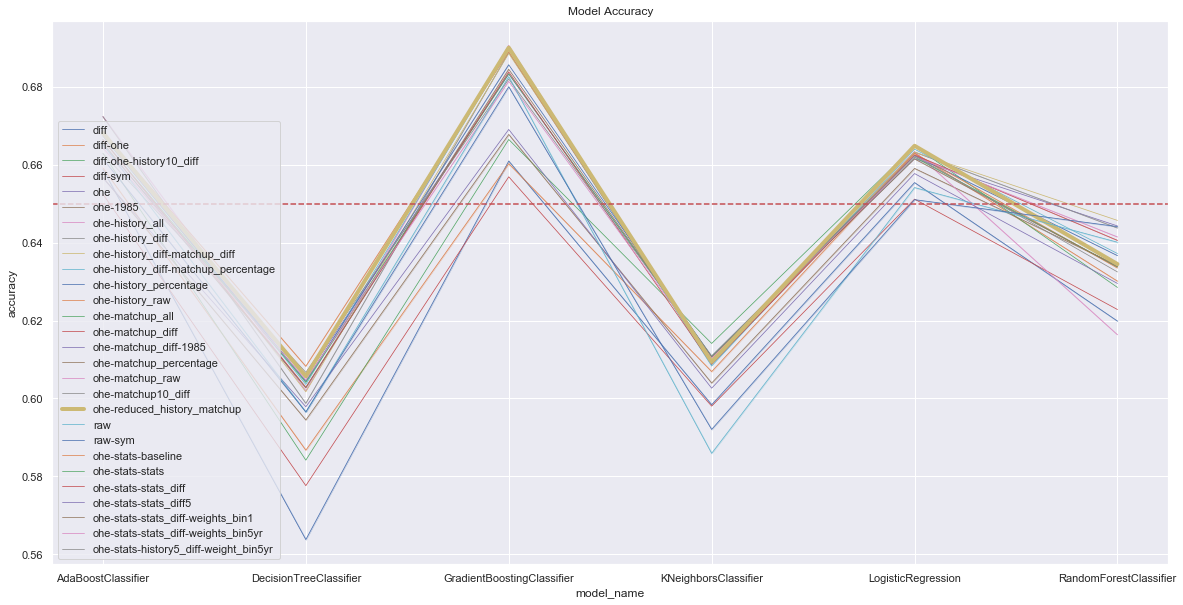

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


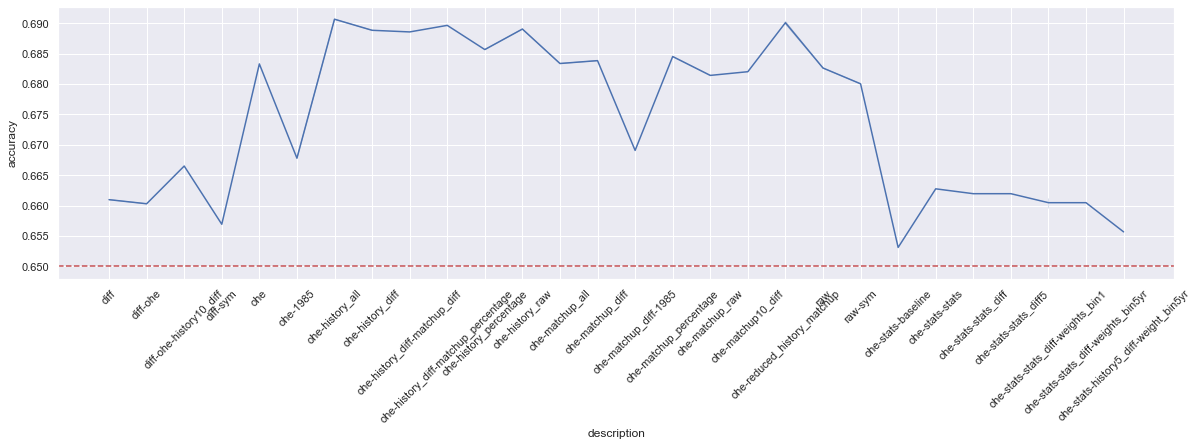

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:

current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


AssertionError: data must of length 1 - got 2

In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

NameError: name 'mw' is not defined

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

NameError: name 'shap_values' is not defined

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

NameError: name 'shap_values' is not defined

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-26 13:41
